In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def calc_constrained_angles(ankle, knee, shoulder, hip_range, elbow_range):
    """
    Given 3 input angles (ankle, knee, shoulder) and valid ranges for hip and elbow,
    solve for constrained angles (hip and elbow) such that:
        - torso is vertical
        - forearm is horizontal

    NOT CURRENTLY TAKING TORSO ANGLE AS INPUT, SO BACK INCLINATION MUST MATCH
    
    
    """
    foot_angle = 180
    
    lowerleg_angle = ankle 
    
    thigh_angle = 180 - (knee - lowerleg_angle)

    torso_angle = 100 
    
    hip = torso_angle + (knee - ankle)
    
    upperarm_angle = 190 + torso_angle + shoulder
    
    elbow = torso_angle + shoulder
    
    forearm_angle = 0

    if not (hip_range[0] <= hip <= hip_range[1]):
        #print('Hip : ', hip)
        return None
    if not (elbow_range[0] <= elbow <= elbow_range[1]):
        #print('Elbow : ', elbow)
        return None

    return [foot_angle, lowerleg_angle, thigh_angle, torso_angle, upperarm_angle, forearm_angle]

def calc_joint_positions_editted(df, gender, percentile, angles):    
    
    # Takes angles relative to x axis as inputs
    
    foot_length = df['FootLength'][f'{gender}{percentile}']  
    lower_leg = df['LowerLeg'][f'{gender}{percentile}']
    thigh_length = df['ThighLength'][f'{gender}{percentile}']
    torso_height = df['TorsoHeight'][f'{gender}{percentile}'] 
    upper_arm = df['UpperArm'][f'{gender}{percentile}'] 
    forearm = df['Forearm'][f'{gender}{percentile}']

    dimensions = [foot_length, lower_leg, thigh_length, torso_height, upper_arm, forearm]

    joints = [(0, 0)]  # starting point for the foot
    
    # Iterate through each body part to calculate the next joint position
    for i in range(len(dimensions)):
        # Extract the current joint position, length of the current body part, and angle
        x_prev, y_prev = joints[-1]
        length = dimensions[i]
        angle = angles[i]
        
        # Calculate the new joint position using trigonometry
        x_new = x_prev + length * np.cos(np.radians(angle))
        y_new = y_prev + length * np.sin(np.radians(angle))
        
        # Add the new joint position to the list of joints
        joints.append((x_new, y_new))

    return joints

def calculate_distances(joints):
    foot_x, foot_y = joints[0]
    hand_x, hand_y = joints[6]
    torso_x, torso_y = joints[3]

    # A: Horizontal distance between the free end of the hand and the joint connecting the thigh to the torso
    distance_A = abs(hand_x - torso_x)
    
    # B: Vertical distance between the free end of the foot and the free end of the hand
    distance_B = abs(hand_y - foot_y)

    # C: Vertical distance between the free end of the foot and the joint connecting the thigh to the torso
    distance_C = abs(torso_y - foot_y)
    
    # D: Horizontal distance between the free end of the foot and the joint connecting the thigh to the torso
    distance_D = abs(torso_x - foot_x)

    return distance_A, distance_B, distance_C, distance_D


In [10]:
df = pd.read_csv('adultdata_data.csv')
data = df.set_index('Dimension').transpose()

In [11]:

# Input gender, percentile and back inclination angle
gender = 'Woman'
percentile = '5'
back_inclination = 95    

# Define the ranges for angles a, b, and d
ankle = np.arange(80,121,1)  
knee = np.arange(80,121,1)
shoulder = np.arange(0,31,1)  

# # Create an empty 3D array to store the results (using lists of lists of lists)
# A = np.full((len(range_1), len(range_2), len(range_3)), None)
# B = np.full((len(range_1), len(range_2), len(range_3)), None)
# C = np.full((len(range_1), len(range_2), len(range_3)), None)
# D = np.full((len(range_1), len(range_2), len(range_3)), None)

A = np.full((len(ankle), len(knee), len(shoulder)), np.nan, dtype=float)
B = np.full_like(A, np.nan)
C = np.full_like(A, np.nan)
D = np.full_like(A, np.nan)
angle_list = np.full((len(ankle), len(knee), len(shoulder)), np.nan, dtype=object)

hip_range = (80, 120)      # Valid range for c
elbow_range = (80, 120)   # Valid range for e

for i, a in enumerate(ankle):  # ankle
    for j, b in enumerate(knee):  # knee
        for k, d in enumerate(shoulder):  # shoulder
            # Try to solve for constrained angles
            
            angles_in = calc_constrained_angles(a, b, d, hip_range, elbow_range)

            if angles_in is None:
                # Invalid combo — fill with NaNs
                A[i, j, k] = np.nan
                B[i, j, k] = np.nan
                C[i, j, k] = np.nan
                D[i, j, k] = np.nan
                angle_list[i, j, k] = np.nan
            
            else:
                joints = calc_joint_positions_editted(data, gender, percentile, angles_in)
                
                if joints[6][1] < joints[2][1]:
                    # Invalid combo — fill with NaNs
                    A[i, j, k] = np.nan
                    B[i, j, k] = np.nan
                    C[i, j, k] = np.nan
                    D[i, j, k] = np.nan
                    angle_list[i, j, k] = np.nan
                else:
                    distance_A, distance_B, distance_C, distance_D = calculate_distances(joints)
                
                    # Store results
                    A[i, j, k] = distance_A
                    B[i, j, k] = distance_B
                    C[i, j, k] = distance_C
                    D[i, j, k] = distance_D
                    angle_list[i, j, k] = angles_in
                
valid_count = np.sum(~np.isnan(A))
print(f"Valid combinations: {valid_count} / {A.size}")


Valid combinations: 24573 / 52111


In [12]:
min_B = np.nanmin(B)
print(f"Minimum value of B: {min_B}")

index_min_B = np.unravel_index(np.nanargmin(B), B.shape)
print(f"Index corresponding to the minimum value of B: {index_min_B}")

Minimum value of B: 291.76630757725195
Index corresponding to the minimum value of B: (np.int64(40), np.int64(20), np.int64(18))


In [13]:
angles_min_B = angle_list[index_min_B]
angles_min_B

[180, np.int64(120), np.int64(200), 100, np.int64(308), 0]

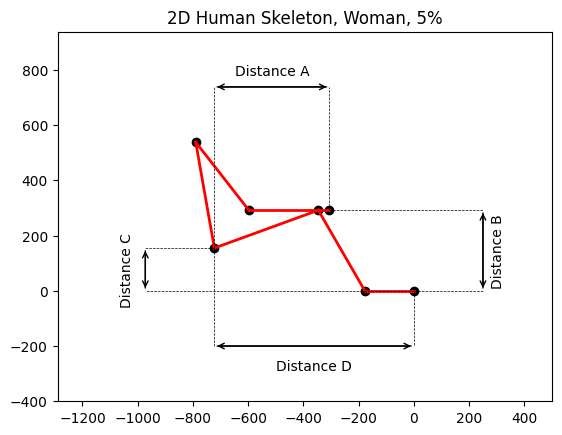

In [16]:
from tools import plot_skeleton 

joints_min_B = calc_joint_positions_editted(data, gender, percentile, angles_min_B)
plot_skeleton(joints_min_B, dists = True, gender=gender, percentile=percentile, overlay=False)
